## Hamiltonian Simulation

We want to construct a quantum circuit that simulates the unitary evolution

$$
U(\Delta t) = e^{-i \Delta t \mathcal{H}}, \quad \text{e.g.} \; \mathcal{H} = X_1 \otimes Y_2 \otimes Z_3.
$$

### Motivation

Simulating the time evolution of quantum systems governed by a Hamiltonian is a central application of quantum computing. 
Given a Hamiltonian $\mathcal{H}$, the dynamics of a quantum state are described by the unitary operator:

$$
U(t) = e^{-i \mathcal{H} t}.
$$

In many physically relevant models (spin systems, quantum chemistry, lattice models), the Hamiltonian can be decomposed as a sum of *Pauli strings*:

$$
\mathcal{H} = \sum_k c_k \, P_k, \quad P_k \in \{I, X, Y, Z\}^{\otimes n}.
$$

Efficiently implementing the time evolution operator

$$
U(t) = e^{-i \Delta t \, P_k}
$$

for a single Pauli string $P_k$ is a fundamental building block of:
- Trotterized time evolution
- Variational Quantum Eigensolvers (VQE)
- Quantum simulation of many-body systems
- Hamiltonian-based Quantum Neural Networks

---

### Core Idea

Any Pauli string can be mapped to a product of $Z$ operators via **local basis changes**, enabling diagonal evolution:

| Pauli | Basis change | Undo basis change |
|-------|-------------|-----------------|
| $X$     | $H$           | $H$               |
| $Y$     | $S^† H$        | $H S$             |
| $Z$     | $I$           | $I$               |

Once mapped to $Z^{\otimes k}$, the operator becomes diagonal. Its eigenvalues correspond to the **parity** of the qubits.  

By computing this parity onto an **ancilla qubit**, we can apply a controlled phase rotation:

$$
e^{-i \Delta t Z^{\otimes k}} \longrightarrow R_z(2 \Delta t)
$$

> **Note:** The factor of 2 arises because the parity encoding maps eigenvalues $\pm 1$ to a phase $\pm \Delta t$, so doubling the rotation angle ensures correct evolution.

Finally, we reverse all steps to restore the original basis.

---

### Circuit Structure

The full evolution circuit consists of the following steps:

1. **Basis change**: Map all Pauli operators in the string to $Z$.
2. **Parity computation**: Use a ladder of CNOT gates to encode the parity of the Pauli string onto an ancilla qubit (the last qubit).
3. **Phase rotation**: Apply a single $R_z(2\Delta t)$ rotation to the ancilla.
4. **Uncompute parity**: Reverse the CNOT ladder.
5. **Undo basis change**: Return all qubits to their original Pauli bases.

The following Python class constructs the evolution circuit for an arbitrary Pauli string.  

In [40]:
from qiskit import QuantumCircuit

class PauliStringEvolverWithAncilla:
    """
    Implements the unitary evolution operator:
    U = exp(-i * delta_t * (σ_1 ⊗ σ_2 ⊗ ... ⊗ σ_n))
    using an ancilla-assisted parity-check approach.
    """
    def __init__(self, pauli_string, delta_t):
        self.pauli_string = pauli_string.upper()
        self.n = len(pauli_string)
        self.delta_t = delta_t
        self.qc = QuantumCircuit(self.n + 1)  # +1 for ancilla
        self.ancilla = self.n  # last qubit is ancilla
        self._build()
        
        
    def _basis_change(self):
        """Map each Pauli to Z by basis change."""
        for q, p in enumerate(self.pauli_string):
            if p == "X":
                self.qc.h(q)
                self.qc.barrier()
            elif p == "Y":
                self.qc.sdg(q)
                self.qc.h(q)
                self.qc.barrier()
            elif p in ["Z", "I"]:
                pass
            else:
                raise ValueError(f"Invalid Pauli {p} in string {self.pauli_string}")

                
    def _parity_check(self):
        """Compute the parity of the Pauli string on the ancilla qubit using CNOTs."""
        for i in range(self.n):
            if self.pauli_string[i] != "I":  # skip identity
                self.qc.cx(i, self.ancilla)
                
                
    def _rotation(self):
        """Apply phase rotation on the ancilla."""
        self.qc.rz(2 * self.delta_t, self.ancilla)
        
        
    def _undo_parity(self):
        """Undo the CNOT ladder in reverse order."""
        for i in reversed(range(self.n)):
            if self.pauli_string[i] != "I":
                self.qc.cx(i, self.ancilla)             

    
    def _undo_basis_change(self):
        """Undo basis changes in reverse order."""
        for i, p in reversed(list(enumerate(self.pauli_string))):
            if p == "Y":
                self.qc.barrier()
                self.qc.h(i)
                self.qc.s(i)
                self.qc.barrier()
            elif p == "X":
                self.qc.h(i)
                self.qc.barrier()

    
    def _build(self):
        """Construct the full evolution circuit."""
        self._basis_change()
        self._parity_check()
        self._rotation()
        self._undo_parity()
        self._undo_basis_change()

    
    def draw(self, style="mpl"):
        return self.qc.draw(style)
    
    def summary(self):
        print(f"Pauli string: {self.pauli_string}")
        print(f"Δt = {self.delta_t}")
        print("Number of qubits:", self.qc.num_qubits)
        print("Circuit depth:", self.qc.depth())

We now demonstrate the evolution operator for a simple Pauli string.

Pauli string: XYZ
Δt = 0.3
Number of qubits: 4
Circuit depth: 13


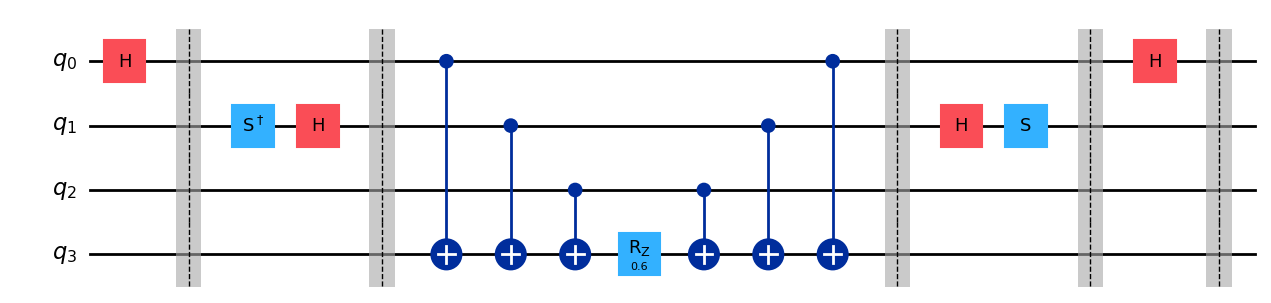

In [45]:
# Example: evolve with H = X ⊗ Y ⊗ Z, Δt = 0.5
evolver = PauliStringEvolverWithAncilla("XYZ", delta_t=0.3)
evolver.summary()
evolver.draw("mpl")

This circuit implements the unitary:

$$
U = e^{-i \, 0.3 \, (X \otimes Y \otimes Z)}
$$

using 3 system qubits and 1 ancilla qubit.

> **Note:** The last qubit of the circuit is always the ancilla.

---
### Physical Interpretation

- The **ancilla qubit** acts as a *phase accumulator*, encoding the collective eigenvalue of the Pauli string.
- This method avoids multi-controlled phase gates and scales efficiently with the length of the Pauli string.
- By using only **single-qubit rotations** and **CNOT gates**, we can implement nontrivial multi-qubit interactions.

#### Why This Matters

This ancilla-assisted approach provides a **conceptual bridge** between:
- Abstract Hamiltonian physics
- Concrete quantum circuit implementations

It forms the backbone of:
- Trotter–Suzuki Hamiltonian simulation
- Variational algorithms such as VQE
- Hamiltonian-based quantum machine learning models

---

### Conclusion

We have implemented an **ancilla-assisted exact circuit** for simulating the evolution of a single Pauli-string Hamiltonian term.  
This construction serves as a fundamental building block for **scalable quantum simulation algorithms** and **Hamiltonian-based quantum neural networks**.  
The method is efficient, physically transparent, and will be reused extensively in more advanced Hamiltonian-based models.